In this method we slide are convolurion layer along time samples (ex - [10,882] ).batch size is changed after one convolution.number of convolution layers decide the output atch size.
example - 
B = 10
L = 882


In [ ]:
import numpy as np
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import joblib
import torch.optim as optim
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import soundfile as sf
import librosa
import matplotlib.pyplot as plt
import librosa.display

#creating neural network


class OneDConvBlock(nn.Module):
    def __init__(self,B,H,L,P,Sc,dil):
        super().__init__()
        '''B - number of inut channels
           L - Length of filters (in samples)
           H - number of channels in the convolutional blocks
           P - kernal size in convolution blocks
           Sc - Number of channels in the skip connection which gets summed up to use as a output in TCN
           dil - dilation factor 1,2,4,8,.. '''
        pad    =   math.floor(dil*(P-1)/2)
        self.pointConv1 = nn.Conv1d(B,H,P,stride=1,padding=pad,dilation=dil,padding_mode='zeros')   #when padding = dilation L wont change
        self.normalization = nn.BatchNorm1d(L)
        self.Dconv = nn.Conv1d(H,H,P,stride=1,padding=pad,dilation=dil,padding_mode='zeros')
        self.pointConv2 = nn.Conv1d(H,B,P,stride=1,padding=pad,dilation=dil,padding_mode='zeros')
        self.pointConv3 = nn.Conv1d(H,Sc,P,stride=1,padding=pad,dilation=dil,padding_mode='zeros')

    def forwardnet(self, x):
        inp = x
        x = F.rrelu(self.pointConv1(x))
        x = self.normalization(x)
        x = F.rrelu(self.Dconv(x))
        x = self.normalization(x)
        y = self.pointConv3(x)        #skip connection   [Sc,L]
        x = self.pointConv2(x)+inp    #output goes in to the next 1-D conv block [B,L]
        
        return x,y


class separator_block(nn.Module):                          #8 1Dconv blocks in one column  H.shape=[1,8] , Kernal.shape = [1,8]  (kernal vector should consist only odd values)
    def __init__(self,reduced_time_size,H,kernal,inp_batch_size):         #we can input H vector consist of varying sizes for H and a vector for varying kernal size, inp_batch_size to variable batch sizes
      super().__init__()
      self.TCN0 = OneDConvBlock(inp_batch_size, H[0], reduced_time_size ,kernal[0] , inp_batch_size, 1)
      self.TCN1 = OneDConvBlock(inp_batch_size, H[1], reduced_time_size ,kernal[1] , inp_batch_size, 2)
      self.TCN2 = OneDConvBlock(inp_batch_size, H[2], reduced_time_size ,kernal[2] , inp_batch_size, 4)
      self.TCN3 = OneDConvBlock(inp_batch_size, H[3], reduced_time_size ,kernal[3] , inp_batch_size, 8)
      self.TCN4 = OneDConvBlock(inp_batch_size, H[4], reduced_time_size ,kernal[4] , inp_batch_size, 16)
      self.TCN5 = OneDConvBlock(inp_batch_size, H[5], reduced_time_size ,kernal[5] , inp_batch_size, 32)
      self.TCN6 = OneDConvBlock(inp_batch_size, H[6], reduced_time_size ,kernal[6] , inp_batch_size, 64)
      self.TCN7 = OneDConvBlock(inp_batch_size, H[7], reduced_time_size ,kernal[7] , inp_batch_size, 128)
      self.TCN8 = OneDConvBlock(inp_batch_size, H[7], reduced_time_size ,kernal[7] , inp_batch_size, 256)
      self.TCN9 = OneDConvBlock(inp_batch_size, H[7], reduced_time_size ,kernal[7] , inp_batch_size, 512)
      #self.TCN10 = OneDConvBlock(inp_batch_size, H[7], reduced_time_size ,kernal[7] , inp_batch_size, 1024)
      #self.TCN11 = OneDConvBlock(inp_batch_size, H[7], reduced_time_size ,kernal[7] , inp_batch_size, 2048)

    def forwardsep(self,x):
      out,skip = self.TCN0.forwardnet(x)
      sum      = skip
      out,skip = self.TCN1.forwardnet(out)
      sum      = sum + skip
      out,skip = self.TCN2.forwardnet(out)
      sum      = sum + skip
      out,skip = self.TCN3.forwardnet(out)
      sum      = sum + skip
      out,skip = self.TCN4.forwardnet(out)
      sum      = sum + skip
      out,skip = self.TCN5.forwardnet(out)
      sum      = sum + skip
      out,skip = self.TCN6.forwardnet(out)
      sum      = sum + skip
      out,skip = self.TCN7.forwardnet(out)
      sum      = sum + skip
      out,skip = self.TCN8.forwardnet(out)
      sum      = sum + skip
      out,skip = self.TCN9.forwardnet(out)
      sum      = sum + skip
      #out,skip = self.TCN10.forwardnet(out)
      #sum      = sum + skip
      #out,skip = self.TCN11.forwardnet(out)
      #sum      = sum + skip
      return out,sum

    
#creating neural network
class convTasnet(nn.Module):
    def __init__(self,batch_size,time_window_size):       #M - number of conv1D blocks in a column  , N - number of columns 
      nn.Module.__init__(self)
      reduced_time_size = math.floor(time_window_size/2)                                                            #the number of features of the output from encoder(reduced input)
      kernal_size = 3  
                                                                                                  #kernal size should be less than the L value of theoneDconv block
      self.encoder = OneDConvBlock(time_window_size,reduced_time_size,batch_size,kernal_size,reduced_time_size,1)   #dimension reduction. If input.shape(batch_size,time_window_size) what we need to reduce is time_window_size,Number of samples in order to transform the waveform in to a different representation.most probably the transpose of the input signal is insered here
      self.layerNorm = nn.LayerNorm(reduced_time_size)                                                              #traspose the output of encoder in oreder  to get [batch_size,time_window_size] form.Because of dimensionality reduction time_window_size will be reduced 
      self.one_X_oneconv = nn.Conv1d(batch_size , batch_size, 7 ,stride=1, padding=3 , dilation=1 ,padding_mode='zeros')  #to get exact input shape as output,by restricting padding variable , padding = [stride*(Lout-1)-Lin + dilation * (kernal size -1) + 1]/2
      
      #Separator
      self.column1  = separator_block(reduced_time_size,[10,5,10,15,10,5,8,10],[3,5,3,5,7,3,9,13],batch_size)
      self.column2  = separator_block(reduced_time_size,[7,5,10,20,18,24,12,5],[3,5,3,5,7,3,9,13],batch_size)
      self.column3  = separator_block(reduced_time_size,[10,5,10,15,10,5,8,10],[3,5,3,5,7,3,9,13],batch_size)
      self.column4  = separator_block(reduced_time_size,[10,5,10,15,10,5,8,10],[3,5,3,5,7,3,9,13],batch_size)
      self.column5  = separator_block(reduced_time_size,[10,5,10,15,10,5,8,10],[3,5,3,5,7,3,9,13],batch_size)
      self.column6  = separator_block(reduced_time_size,[10,5,10,15,10,5,8,10],[3,5,3,5,7,3,9,13],batch_size)
      self.column7  = separator_block(reduced_time_size,[10,5,10,15,10,5,8,10],[3,5,3,5,7,3,9,3],batch_size)
      self.column8  = separator_block(reduced_time_size,[10,5,10,15,10,5,8,10],[3,5,3,5,7,3,9,13],batch_size)
      self.column9  = separator_block(reduced_time_size,[10,5,10,15,10,5,8,10],[3,5,3,5,7,3,9,13],batch_size)
      self.column10  = separator_block(reduced_time_size,[10,5,10,15,10,5,8,10],[3,5,3,5,7,3,9,13],batch_size)
      self.column11  = separator_block(reduced_time_size,[10,5,10,15,10,5,8,10],[3,5,3,5,7,3,9,13],batch_size)
      self.column12  = separator_block(reduced_time_size,[10,5,10,15,10,5,8,10],[3,5,3,5,7,3,9,13],batch_size)
      self.column13  = separator_block(reduced_time_size,[10,5,10,15,10,5,8,10],[3,5,3,5,7,3,9,13],batch_size)
      self.column14  = separator_block(reduced_time_size,[10,5,10,15,10,5,8,10],[3,5,3,5,7,3,9,13],batch_size)
      self.column15  = separator_block(reduced_time_size,[10,5,10,15,10,5,8,10],[3,5,3,5,7,3,9,13],batch_size)
      self.column16  = separator_block(reduced_time_size,[10,5,10,15,10,5,8,10],[3,5,3,5,7,3,9,13],batch_size)

      self.one_X_oneconv2 = nn.Conv1d(batch_size , batch_size, 7 ,stride=1, padding=3 , dilation=1 ,padding_mode='zeros')
      self.decoder = OneDConvBlock(reduced_time_size,reduced_time_size*2,batch_size,kernal_size,time_window_size,1)           #should increase time window size.hence the transposed signal is fed to the convD layer

    def forward(self, x):                                             #x = [batch size,time window size] -----> we get the input in this form
      y,x     = self.encoder.forwardnet(torch.transpose(x,0,1))       #x = [reduced time window size,batch size] --->this is the parameter we pass inside to the neural network
      mixture = torch.transpose(x,0,1)                                #x = [batch size,time window size]------>multiply this with the masks derived elemant wise

      x       = self.layerNorm(torch.transpose(x,0,1))                #x = [batch size,reduced time window size] ----> transpose before normalizing because normalization is done over samples and not over batches
      x       = self.one_X_oneconv(x)                                 #x = [batch size,reduced time window size] ---->all the settings (stride,dilation,padding) are selected such that the size wont change
      
      x,sum1   = self.column1.forwardsep(x)                           #x = [batch size,reduced time window size]-----> x is fed into the next neural network  ,  sum = [batch size,reduced time window size]
      x,sum2   = self.column2.forwardsep(x)
      x,sum3   = self.column3.forwardsep(x)
      x,sum4   = self.column4.forwardsep(x)
      x,sum5   = self.column5.forwardsep(x)
      x,sum6   = self.column6.forwardsep(x)
      x,sum7   = self.column7.forwardsep(x)
      x,sum8   = self.column8.forwardsep(x)
      x,sum9   = self.column9.forwardsep(x)
      x,sum10   = self.column10.forwardsep(x)
      x,sum11   = self.column10.forwardsep(x)
      x,sum12   = self.column10.forwardsep(x)
      x,sum13   = self.column10.forwardsep(x)
      x,sum14   = self.column10.forwardsep(x)
      x,sum15   = self.column10.forwardsep(x)
      x,sum16   = self.column10.forwardsep(x)

      sum      = F.rrelu(sum1+sum2+sum3+sum4+sum5+sum6+sum7+sum8+sum9+sum10+sum11+sum12+sum13+sum14+sum15+sum16)
      mask     = torch.sigmoid(self.one_X_oneconv(sum))                #sum = [batch size,reduced time window size]
      decod    = torch.mul(mask,mixture)                               #to_decode = [batch size,reduced time window size]

      out,sep      = self.decoder.forwardnet(torch.transpose(decod,0,1))
      return torch.transpose(sep,0,1)


    
    

class SISNR(nn.Module):
  def __init__(self,time_window_size):
    super(SISNR,self).__init__();
    self.time_window_size=time_window_size
    #self.MSErr = nn.mse_loss()
  def forward(self,predictions, target):
    
    #predictions = Variable(predictions, requires_grad=True)
    #target      = Variable(target, requires_grad=True)
    predictions= torch.reshape(predictions,(-1,1))
    target     = torch.reshape(target,(-1,1))
    starget    = torch.matmul(torch.transpose(predictions,0,1),target)
    starget    = torch.mul(starget,target)
    temp       = torch.matmul(torch.transpose(target,0,1), target)
    starget    = torch.div(starget,temp)
    #enoise     = F.mse_loss(predictions , starget)
    enoise     = torch.sub(predictions , starget)
    starget    = torch.matmul(torch.transpose(starget,0,1), starget)
    enoise     = torch.matmul(torch.transpose(enoise,0,1), enoise)
    loss_value = 10*torch.log10(torch.div(   starget , enoise    ))
    
    return loss_value #snr ---> signal/noise ,to optimize signal should go higher and noise should go down which makees the loss value go up when optimizing.Since pytorchs backward is made to minimize the loss we use 1/loss_value



In [ ]:
dataset_path = input("dataset_path - ")
train_set=torch.load(dataset_path)
train_set=train_set.cuda()

batch_size = int(input("batch_size - "))
time_window_size = int(input("time_window_size - "))
learning_rate = float(input("learning rate - "))
epochs = int(input("epochs - "))

net = convTasnet(batch_size,time_window_size).to('cuda')
loss_function = SISNR(time_window_size)  #torch.nn.GaussianNLLLoss
optimizer = optim.Adam(net.parameters(), lr=learning_rate ,maximize = True)

dataset_path - /content/drive/Shareddrives/G-33-2022/Software/Dataset batch size_512, time window size_4096_no flip.pt
batch_size - 512
time_window_size - 4096
learning rate - 0.0001
epochs - 100


In [ ]:

net = joblib.load('/content/drive/Shareddrives/G-33-2022/Software/100 epochs sisnr batch size 512 time window size 4096 encoding factor 2.pkl ')
#net = convTasnet(batch_size,time_window_size).to('cuda')
optimizer = optim.Adam(net.parameters(), lr=0.0001 ,maximize = True)

In [ ]:
loss_vector=[]
for epoch in range(epochs): # 3 full passes over the data
    net.train()
    for data in range(len(train_set[0])):  #len(train_set[0]) `data` is a batch of data
        x = train_set[0][data].to('cuda')  # X is the batch of features, y is the batch of targets.
        y = train_set[1][data].to('cuda')
        net.zero_grad()  # sets gradients to 0 before loss calc. You will do this likely every step.
        output = net(x)  # pass in the reshaped batch (recall they are 28x28 atm)
        loss = loss_function.forward(output, y)  # calc and grab the loss value (good candidate - smooth_l1_loss) F.mse_loss loss_function.forward
        #loss = Variable(loss,requires_grad=True)
        loss.backward()  # apply this loss backwards thru the network's parameters
        optimizer.step()  # attempt to optimize weights to account for loss/gradients
    loss_vector.append(loss)
    print(epoch,loss) 


joblib.dump(net, '/content/drive/Shareddrives/G-33-2022/Software/Trained_NN_1.pkl')

0 tensor([[10.7116]], device='cuda:0', grad_fn=<MulBackward0>)
1 tensor([[10.7412]], device='cuda:0', grad_fn=<MulBackward0>)
2 tensor([[10.7532]], device='cuda:0', grad_fn=<MulBackward0>)
3 tensor([[10.8482]], device='cuda:0', grad_fn=<MulBackward0>)
4 tensor([[10.8629]], device='cuda:0', grad_fn=<MulBackward0>)
5 tensor([[10.9188]], device='cuda:0', grad_fn=<MulBackward0>)


KeyboardInterrupt: ignored

In [ ]:
for name, param in net.named_parameters():
    print(name, '\t\t', param.shape)

In [ ]:
train_set=train_set.to('cuda')
train_set.device

In [ ]:
for name, param in net.named_parameters():
    print(name, '\t\t', param.shape)

In [ ]:
net.to('cuda')

In [ ]:
for n, p in net.named_parameters():
    print(p.device, '', n)

In [ ]:
joblib.dump(net, '/content/drive/Shareddrives/G-33-2022/Software/100 epochs sisnr batch size 512 time window size 4096 encoding factor 2.pkl ')

['/content/drive/Shareddrives/G-33-2022/Software/100 epochs sisnr batch size 512 time window size 4096 encoding factor 2.pkl ']

[-19.101823806762695, -14.406579971313477, -12.15225601196289, -10.660833358764648, -9.509828567504883, -8.493803977966309, -7.528319835662842, -6.724861145019531, -5.968709468841553, -5.198561668395996, -4.511529445648193, -3.8979432582855225, -3.3286049365997314, -2.8192784786224365, -2.3510890007019043, -1.975062608718872, -1.7677603960037231, -1.5840957164764404, -1.164964199066162, -0.9204187393188477, -0.5618791580200195, -0.27609091997146606, -0.16860388219356537, 0.2985495626926422, 0.33445727825164795, 0.7171115279197693, 1.0210378170013428, 0.9700887203216553, 1.2882651090621948, 1.7424235343933105, 1.8634997606277466, 2.218487501144409, 2.1013638973236084, 2.4573633670806885, 2.7356081008911133, 2.9321420192718506, 3.017624616622925, 3.055006504058838, 3.210270404815674, 3.4569268226623535, 3.6530792713165283, 3.77487850189209, 3.877840280532837, 3.873368263244629, 4.010158061981201, 3.9902756214141846, 4.301612854003906, 4.392058849334717, 4.526248455047607, 4.5478401184082

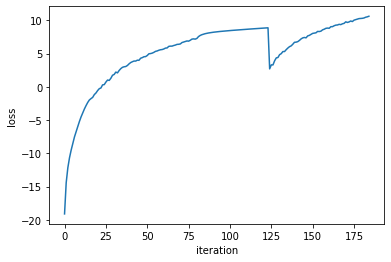

In [ ]:

#Lv = [] 
for i in range(len(loss_vector)):
    Lv.append(loss_vector[i].item())
print(Lv)
plt.plot(Lv)
plt.xlabel("iteration")
plt.ylabel("loss")

plt.show()

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import soundfile as sf
import librosa
import matplotlib.pyplot as plt
import librosa.display

m = input('mix path - ')
n = input('vocal path - ')
(test, sr)=librosa.load(m)
(vocal, sr)=librosa.load(n)
n = min(len(vocal),len(test))
test=test[0:n]+vocal[0:n]

vocal = librosa.util.normalize(vocal)
test = librosa.util.normalize(test)



def make_dataset(a,b,shuffle,batch_size,time_window_size,overlapping):        #shuffle is boolean 1 or 0 , batch size > 0. time_window_size = 882 means 20 micrsecond samples are taken in to account,a = input data,b=output expected data,overlapping===> if data overlaps 1,else 0

  data_size = math.floor(len(a)/time_window_size)     #size of data,when more data gets added change this
  training_data = np.zeros((2,data_size,time_window_size), dtype=np.float32)

#making a dataset of input data audio and expected output audio.training_data[0] corresponds to data we input training data[1] corresponds to expected output data
  for i in range(data_size):
    training_data[0][i] = a[i*time_window_size-bool(overlapping)*bool(i)*int(time_window_size/2) : i*time_window_size+bool(overlapping) * ( bool(i)*int(time_window_size/2)+(1-bool(i))*int(time_window_size) ) +(1-bool(overlapping))*int(time_window_size)]   #training data (here time windows overlap,for not to overlap =  a[i*time_window_size : i*time_window_size+time_window_size] )
    training_data[1][i] = b[i*time_window_size-bool(overlapping)*bool(i)*int(time_window_size/2) : i*time_window_size+bool(overlapping) * ( bool(i)*int(time_window_size/2)+(1-bool(i))*int(time_window_size) ) +(1-bool(overlapping))*int(time_window_size)]  #expected outcome or output data or labels

#shuffle input data to generalise thhe network more
  if (shuffle):
    p = np.random.permutation(len(training_data[1]))
    training_data[0] = training_data[0][p]
    training_data[1] = training_data[1][p]


#dividing in to batch size chunks

  train_set = np.zeros((2,math.floor(data_size/batch_size),batch_size,time_window_size), dtype=np.float32)
  for i in range(math.floor(data_size/batch_size)):
    train_set[0][i] = training_data[0][i*batch_size : i*batch_size+batch_size]
    train_set[1][i] = training_data[1][i*batch_size : i*batch_size+batch_size]

  return train_set



testd = make_dataset(test,vocal,0,batch_size,time_window_size,1)
test_set = torch.from_numpy(testd).to('cuda')

out = torch.zeros(1,time_window_size).to('cuda')                #neural network is designed for batch size data chunks.So we got no option but to send data in [batch_size,time_window] size form. Once a time we send [batch_size,time_window] data chunk and concatanate it with an emptyy tensor.
for i in range(len(test_set[0])):
  out = torch.cat(  (out, net(test_set[0][i])) , 0 )


def audio_retrieval(out,time_window_size,overlapped):   #out is a tensor.we convert it to a numpy array and concatanate all the batch chunks in to one long vector.then we convert it to a audile audio
  #audio = np.empty([1,len(out)*len(out[0])])
  temp = int(time_window_size/2)
  audio=[]
  if (overlapped):
    separated_voice = out[0].detach().numpy()
    audio=np.concatenate((audio,separated_voice))

    for i in range(len(out)-1):
      separated_voice = out[i+1].detach().numpy()
      audio=np.concatenate( (audio[0:-temp], audio[-int(time_window_size/2):-1]+separated_voice[0:int(time_window_size/2)-1], separated_voice[0:int(time_window_size/2)]))
  else:
    audio=[]
    for i in range(len(out)):
      separated_voice = out[i].detach().numpy()
      audio=np.concatenate((audio,separated_voice))

  audio=librosa.util.normalize(audio)
  n = min(len(vocal),len(audio))
  mse = ((vocal[0:n] - audio[0:n])**2).mean(axis=0)
  print("MSE = ",mse)
  return audio

#audio=audio_retrieval(out)
#audio=(audio-np.mean(audio))
#print((audio).shape)
#sf.write('stereo_file.flac',audio, 44100)

#plot data
#plt.figure(1)
#plt.title("original Signal vs predicted signal")
#plt.plot(audio)
#plt.plot(sig_voice)
#plt.show()

aud=audio_retrieval(out[1 :].to('cpu'),time_window_size,0)



sf.write('separated_song1.flac',aud, sr)

mix path - /content/drive/Shareddrives/G-33-2022/Audios/To do/Lacuna_Coil-To_the_edge_Stems/mix.wav
vocal path - /content/drive/Shareddrives/G-33-2022/Audios/To do/Lacuna_Coil-To_the_edge_Stems/Lead_voxes.wav
MSE =  0.01560531587030353


In [ ]:
#sf.write('separated_song1.flac',aud, sr)
sf.write('mix_song1.flac',test, sr)


lakuna mixx - /content/drive/Shareddrives/G-33-2022/Audios/To do/Lacuna_Coil-To_the_edge_Stems/mix.wav

lakuna vocal - /content/drive/Shareddrives/G-33-2022/Audios/To do/Lacuna_Coil-To_the_edge_Stems/Lead_voxes.wav



living the colour mix-  /content/drive/Shareddrives/G-33-2022/Audios/To do/Living Colour/Cult of Personality (Living Colour)/mix.wav

living the colour vocal - /content/drive/Shareddrives/G-33-2022/Audios/To do/Living Colour/Cult of Personality (Living Colour)/song.ogg

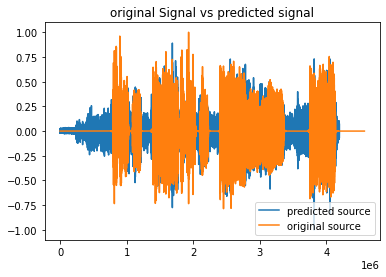

In [ ]:

#plot data
plt.figure(1)
plt.title("original Signal vs predicted signal")
plt.plot(aud)
plt.plot(vocal)

plt.legend(["predicted source", "original source"], loc ="lower right")
plt.show()

[Text(0.5, 1.0, 'Mel-frequency spectrogram song- mix')]

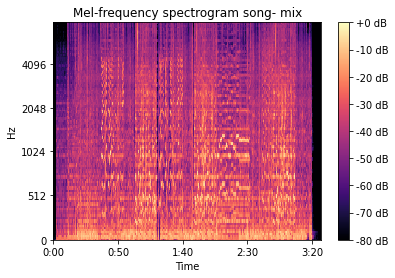

In [ ]:

S = librosa.feature.melspectrogram(y=test, sr=sr, n_mels=128,
                                    fmax=8000)
import matplotlib.pyplot as plt
import librosa.display
fig, ax = plt.subplots()
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram song- mix')

[Text(0.5, 1.0, 'Mel-frequency spectrogram vocal ')]

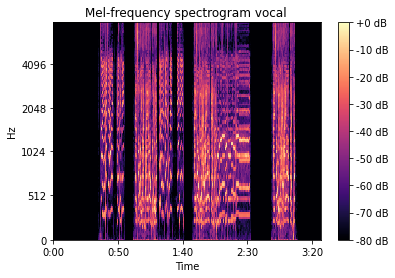

In [ ]:

S = librosa.feature.melspectrogram(y=vocal, sr=sr, n_mels=128,
                                    fmax=8000)

fig, ax = plt.subplots()
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram vocal ')

[Text(0.5, 1.0, 'Mel-frequency spectrogram NN output vocal')]

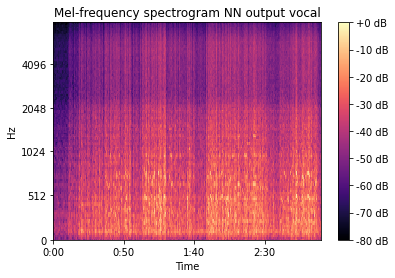

In [ ]:

S = librosa.feature.melspectrogram(y=aud, sr=sr, n_mels=128,
                                    fmax=8000)
import matplotlib.pyplot as plt
import librosa.display
fig, ax = plt.subplots()
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram NN output vocal')

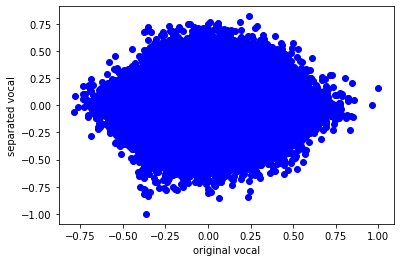

In [ ]:
n = min(len(vocal),len(aud))
plt.scatter(vocal[0:n],aud[0:n], c ="blue")
plt.xlabel("original vocal")
plt.ylabel("separated vocal")
plt.show()

In [ ]:
n = min(len(vocal),len(aud))
mse = ((vocal[0:n] - aud[0:n])**2).mean(axis=0)
print("MSE = ",mse)
loss_function = SISNR(n)
loss = loss_function(torch.tensor(aud[0:n].astype(float)),torch.tensor(vocal[0:n].astype(float)))
print("SISNR = ", loss)

MSE =  0.01699714327432335
SISNR =  tensor([[-87.1711]], dtype=torch.float64)
